# Peer-graded Assignment: Capstone Project

The following questions are being evaluated as part of the peer review submission:

1: Are there unit tests for the API?

2: Are there unit tests for the model?

3: Are there unit tests for the logging?

4: Can all of the unit tests be run with a single script and do all of the unit tests pass?

5: Is there a mechanism to monitor performance?

6: Was there an attempt to isolate the read/write unit tests from production models and logs?

7: Does the API work as expected? For example, can you get predictions for a specific country as well as for all countries combined?

8: Does the data ingestion exists as a function or script to facilitate automation?

9: Were multiple models compared?

10: Did the EDA investigation use visualizations?

11: Is everything containerized within a working Docker image?

12: Did they use a visualization to compare their model to the baseline model?

In [89]:
import os
import sys
import csv
import requests
from collections import Counter
from datetime import date
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Getting started

We will be working with an Flask API to interact with our model. In order to access the different endpoints of this API make sure the app is running. Open a new command prompt and run the app with the command :


```
python path/to/working/directory/app.py -d
```

## TASK 1: Logger test

In [90]:
!python ./unittests/LoggerTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


## TASK 2: Api test

In [91]:
# The API is ready we can test it. We invite you to take a close look into the ApiTests.py script.
!python ./unittests/ApiTests.py

[]


....
----------------------------------------------------------------------
Ran 4 tests in 2.628s

OK


### SOLUTION NOTE

We can now access the logs through the API

In [92]:
r = requests.get('http://127.0.0.1:8080/logs/train-test.log')
print(r.text)

unique_id,timestamp,x_shape,eval_test,model_version,model_version_note,runtime
72d4727b-e991-4a14-a0c5-1b90cf0236df,1731940793.04975,"(100, 10)",{'rmse': 0.5},0.1,test model,00:00:01
bd6906fb-e2ff-4448-a6bc-bd3f325df9eb,1731940793.0502937,"(100, 10)",{'rmse': 0.5},0.1,test model,00:00:01
e3345543-f497-46a1-b19d-eb210376b745,1731940794.889369,all,"('2017-11-30', '2019-05-28')",000:00:01,0.1,{'rmse': 37115}
5af33a0d-36ac-40c3-9a98-8481f3a5c7a9,1731940796.058989,united_kingdom,"('2017-11-29', '2019-05-28')",000:00:01,0.1,{'rmse': 25960}



## TASK 3: Make sure all tests pass

In [93]:
!python run-tests.py

[]
... test flag on
...... subseting data
...... subseting countries
... loading ts data from files:data\cs-train
... saving test version of model: models\test-all-0_1.joblib
... saving test version of model: models\test-united_kingdom-0_1.joblib
... loading ts data from files:data\cs-train
... loading ts data from files:data\cs-train
... loading ts data from files:data\cs-train
2018-01-05
{'y_pred': array([184402.71888]), 'y_proba': None}


...........
----------------------------------------------------------------------
Ran 11 tests in 36.629s

OK


## TASK 4: Performance investigative tooling

In [94]:
! python run-model-train.py

... test flag on
...... subseting data
...... subseting countries
... loading ts data from files:data\cs-train
... saving test version of model: models\test-all-0_1.joblib
... saving test version of model: models\test-united_kingdom-0_1.joblib
... loading ts data from files:data\cs-train
model training complete.


## TASK 5: Describe data

In [95]:
## Describe train data

In [96]:
from cslib import fetch_ts

data_train_dir = os.path.join("data","cs-train")
ts_train_all = fetch_ts(data_train_dir,clean=False)
data_train = []
for key,item in ts_train_all.items():
    print(key,item.shape)
    if key !='all':
        item['country'] = key
        data_train.append(item)

... loading ts data from files:data\cs-train
all (607, 7)
eire (607, 7)
france (607, 7)
germany (607, 7)
hong_kong (426, 7)
netherlands (607, 7)
norway (577, 7)
portugal (607, 7)
singapore (456, 7)
spain (607, 7)
united_kingdom (607, 7)


In [97]:
tb_train = pd.concat(data_train)
year = tb_train['year_month'].apply(lambda x: x.split('-')[0])
tb_train['year'] = year
tb_train.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,country,year
0,2017-11-01,0,0,0,0,2017-11,0.0,eire,2017
1,2017-11-02,0,0,0,0,2017-11,0.0,eire,2017
2,2017-11-03,0,0,0,0,2017-11,0.0,eire,2017
3,2017-11-04,0,0,0,0,2017-11,0.0,eire,2017
4,2017-11-05,0,0,0,0,2017-11,0.0,eire,2017


In [98]:
print( tb_train.groupby(['country'])['revenue'].sum())

country
eire               104589.400
france              38985.420
germany             45651.261
hong_kong           14393.130
netherlands         12296.780
norway              38326.120
portugal            13327.210
singapore           12945.460
spain               15393.360
united_kingdom    3343551.644
Name: revenue, dtype: float64


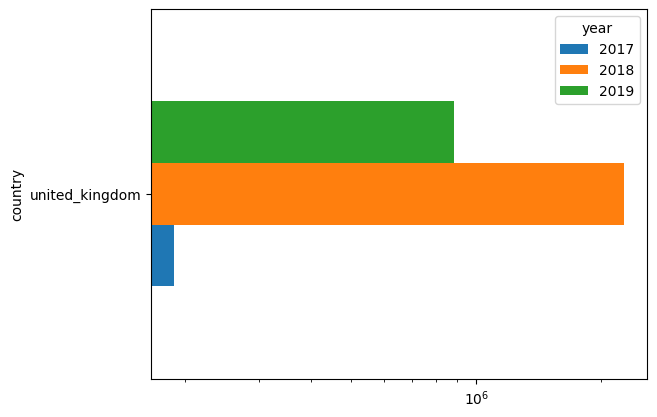

In [99]:
res_train_uk = tb_train[tb_train['country'] == 'united_kingdom'].groupby(['country','year'])['revenue'].sum().unstack()
ax_train_uk = res_train_uk.plot.barh()
ax_train_uk.set_xscale("log")

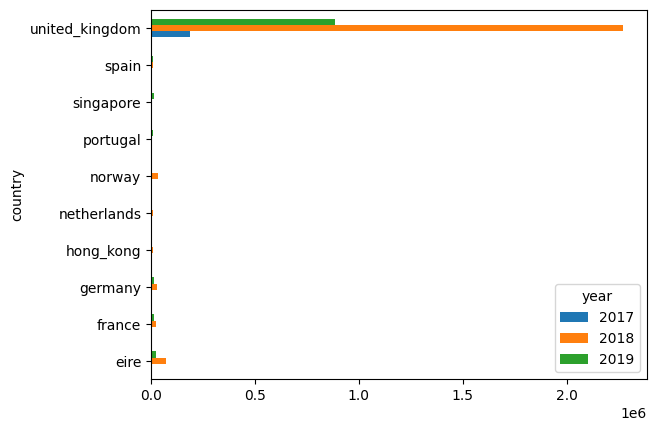

In [100]:
res_train_all = tb_train.groupby(['country','year'])['revenue'].sum().unstack()
ax_train_all = res_train_all.plot.barh()

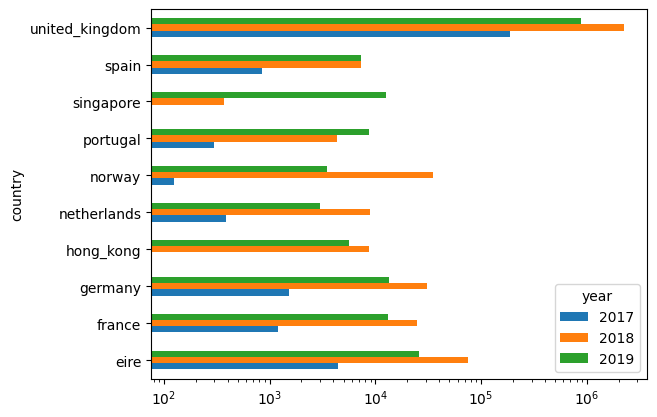

In [101]:
ax_res_train_all_log = res_train_all.plot.barh()
ax_res_train_all_log.set_xscale("log")

In [102]:
## TASK 5: Describe production data

In [103]:
data_prod_dir = os.path.join("data","cs-production")
ts_prod_all = fetch_ts(data_prod_dir,clean=False)
data_prod = []
for key,item in ts_prod_all.items():
    print(key,item.shape)
    if key !='all':
        item['country'] = key
        data_prod.append(item)

... loading ts data from files:data\cs-production
all (122, 7)
belgium (122, 7)
eire (122, 7)
france (122, 7)
germany (122, 7)
hong_kong (92, 7)
netherlands (122, 7)
portugal (122, 7)
singapore (0, 7)
spain (122, 7)
united_kingdom (122, 7)


In [104]:
tb_prod = pd.concat(data_prod)
year = tb_prod['year_month'].apply(lambda x: x.split('-')[0])
tb_prod['year'] = year
tb_prod.head()

C:\Users\garne\AppData\Local\Temp\ipykernel_24864\2283777596.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tb_prod = pd.concat(data_prod)


,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,country,year
0,2019-08-01,21,1,21,131,2019-08,96.25,belgium,2019
1,2019-08-02,0,0,0,0,2019-08,0.00,belgium,2019
2,2019-08-03,0,0,0,0,2019-08,0.00,belgium,2019
3,2019-08-04,0,0,0,0,2019-08,0.00,belgium,2019
4,2019-08-05,0,0,0,0,2019-08,0.00,belgium,2019


In [105]:
print( tb_prod.groupby(['country'])['revenue'].sum())

country
belgium             3344.790
eire               17317.470
france             25852.120
germany            17082.260
hong_kong           5852.110
netherlands         3139.040
portugal            3355.540
spain               4348.000
united_kingdom    822847.322
Name: revenue, dtype: float64


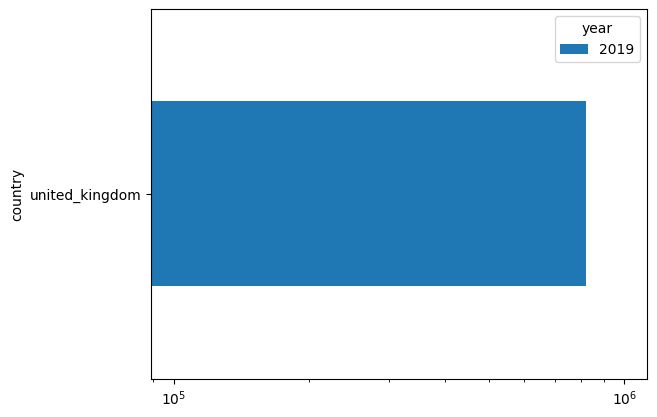

In [106]:
res_prod_uk = tb_prod[tb_prod['country'] == 'united_kingdom'].groupby(['country','year'])['revenue'].sum().unstack()
ax_prod_uk = res_prod_uk.plot.barh()
ax_prod_uk.set_xscale("log")

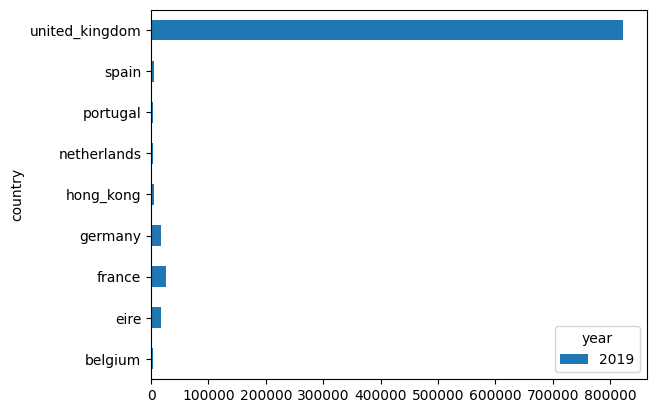

In [107]:
res_prod_all = tb_prod.groupby(['country','year'])['revenue'].sum().unstack()
ax_prod_all = res_prod_all.plot.barh()

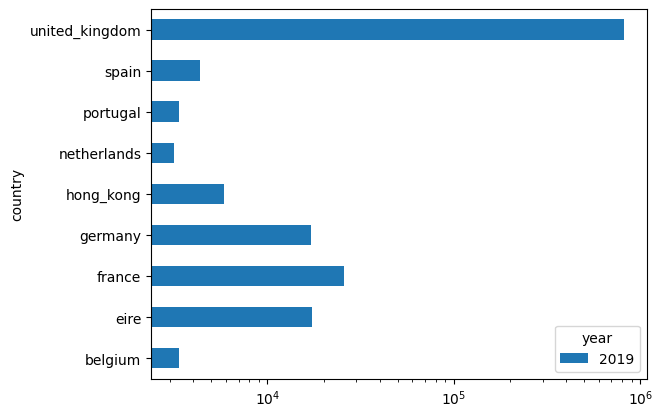

In [108]:
ax_res_prod_all_log = res_prod_all.plot.barh()
ax_res_prod_all_log.set_xscale("log")

In [109]:
from cslib import load_data_from_csv
from model import train_single_country, model_load

df_train_uk = load_data_from_csv(data_train_dir, "ts-", "united_kingdom")
df_train_fr = load_data_from_csv(data_train_dir, "ts-", "france")
df_train_de = load_data_from_csv(data_train_dir, "ts-", "germany")
df_train_ie = load_data_from_csv(data_train_dir, "ts-", "eire")
df_train_sg = load_data_from_csv(data_train_dir, "ts-", "singapore")
df_train_hk = load_data_from_csv(data_train_dir, "ts-", "hong_kong")
df_train_es = load_data_from_csv(data_train_dir, "ts-", "spain")
df_train_pt = load_data_from_csv(data_train_dir, "ts-", "portugal")
df_train_no = load_data_from_csv(data_train_dir, "ts-", "norway")
df_train_nl = load_data_from_csv(data_train_dir, "ts-", "netherlands")

train_single_country(df_train_uk,"united_kingdom","sl",test=False)
train_single_country(df_train_fr,"france","sl",test=False)
train_single_country(df_train_de,"germany","sl",test=False)
train_single_country(df_train_ie,"eire","sl",test=False)
train_single_country(df_train_sg,"singapore","sl",test=False)
train_single_country(df_train_hk,"hong_kong","sl",test=False)
train_single_country(df_train_es,"spain","sl",test=False)
train_single_country(df_train_pt,"portugal","sl",test=False)
train_single_country(df_train_no,"norway","sl",test=False)
train_single_country(df_train_nl,"netherlands","sl",test=False)

... saving model: models\sl-united_kingdom-0_1.joblib
... saving model: models\sl-france-0_1.joblib
... saving model: models\sl-germany-0_1.joblib
... saving model: models\sl-eire-0_1.joblib
... saving model: models\sl-singapore-0_1.joblib
... saving model: models\sl-hong_kong-0_1.joblib
... saving model: models\sl-spain-0_1.joblib
... saving model: models\sl-portugal-0_1.joblib
... saving model: models\sl-norway-0_1.joblib
... saving model: models\sl-netherlands-0_1.joblib


In [110]:
df_prod_uk = load_data_from_csv(data_prod_dir, "ts-", "united_kingdom")
df_prod_fr = load_data_from_csv(data_prod_dir, "ts-", "france")
df_prod_de = load_data_from_csv(data_prod_dir, "ts-", "germany")
df_prod_ie = load_data_from_csv(data_prod_dir, "ts-", "eire")
df_prod_sg = load_data_from_csv(data_prod_dir, "ts-", "singapore")
df_prod_hk = load_data_from_csv(data_prod_dir, "ts-", "hong_kong")
df_prod_es = load_data_from_csv(data_prod_dir, "ts-", "spain")
df_prod_pt = load_data_from_csv(data_prod_dir, "ts-", "portugal")
df_prod_be = load_data_from_csv(data_prod_dir, "ts-", "belgium")
df_prod_nl = load_data_from_csv(data_prod_dir, "ts-", "netherlands")

train_single_country(df_prod_uk,"united_kingdom","prod",test=False)
train_single_country(df_prod_fr,"france","prod",test=False)
train_single_country(df_prod_de,"germany","prod",test=False)
train_single_country(df_prod_ie,"eire","prod",test=False)
train_single_country(df_prod_sg,"singapore","prod",test=False)
train_single_country(df_prod_hk,"hong_kong","prod",test=False)
train_single_country(df_prod_es,"spain","prod",test=False)
train_single_country(df_prod_pt,"portugal","prod",test=False)
train_single_country(df_prod_be,"belgium","prod",test=False)
train_single_country(df_prod_nl,"netherlands","prod",test=False)

... saving model: models\prod-united_kingdom-0_1.joblib
... saving model: models\prod-france-0_1.joblib
... saving model: models\prod-germany-0_1.joblib
... saving model: models\prod-eire-0_1.joblib
... saving model: models\prod-hong_kong-0_1.joblib
... saving model: models\prod-spain-0_1.joblib
... saving model: models\prod-portugal-0_1.joblib
... saving model: models\prod-belgium-0_1.joblib
... saving model: models\prod-netherlands-0_1.joblib


In [111]:
print("Loading sl modules")
sl_data_dir = os.path.join("data","cs-train")
all_sl_data, all_sl_models = model_load("sl",data_dir=sl_data_dir,training=True)
print("... models loaded: ",",".join(all_sl_models.keys()))
print("... data loaded: ",",".join(all_sl_data.keys()))

Loading sl modules
... loading ts data from files:data\cs-train
... models loaded:  eire,france,germany,hong_kong,netherlands,norway,portugal,singapore,spain,united_kingdom
... data loaded:  all,eire,france,germany,hong_kong,netherlands,norway,portugal,singapore,spain,united_kingdom


In [112]:
from model import single_country_predict
## UK predict
country='united_kingdom'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([156861.7415]), 'y_proba': None}


In [113]:
country='france'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([1504.21]), 'y_proba': None}


In [114]:
country='germany'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([2254.382]), 'y_proba': None}


In [115]:
country='eire'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([11642.7585]), 'y_proba': None}


In [116]:
country='singapore'
year='2018'
month='04'
day='25'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-04-25
{'y_pred': array([0.]), 'y_proba': None}


In [117]:
country='hong_kong'
year='2018'
month='04'
day='19'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-04-19
{'y_pred': array([0.]), 'y_proba': None}


In [118]:
country='spain'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([3567.65]), 'y_proba': None}


In [119]:
country='portugal'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([244.54]), 'y_proba': None}


In [120]:
country='norway'
year='2018'
month='09'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-09-05
{'y_pred': array([139.74]), 'y_proba': None}


In [121]:
country='netherlands'
year='2018'
month='01'
day='05'
result = single_country_predict(country,year,month,day,all_sl_models,all_sl_data,test=False)
print(result)

2018-01-05
{'y_pred': array([378.95]), 'y_proba': None}


In [122]:
print("Loading prod modules")
prod_data_dir = os.path.join("data","cs-production")
all_prod_data, all_prod_models = model_load("prod",data_dir=prod_data_dir,training=True)
print("... models loaded: ",",".join(all_prod_models.keys()))
print("... data loaded: ",",".join(all_prod_data.keys()))

Loading prod modules
... loading ts data from files:data\cs-production
... models loaded:  belgium,eire,france,germany,hong_kong,netherlands,portugal,spain,united_kingdom
... data loaded:  all,belgium,eire,france,germany,hong_kong,netherlands,portugal,spain,united_kingdom


In [123]:
country='united_kingdom'
year='2019'
month='10'
day='31'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-31
{'y_pred': array([307510.34666667]), 'y_proba': None}


In [124]:
country='spain'
year='2019'
month='10'
day='31'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-31
{'y_pred': array([1227.734]), 'y_proba': None}


In [125]:
country='portugal'
year='2019'
month='10'
day='31'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-31
{'y_pred': array([615.3156]), 'y_proba': None}


In [126]:
country='netherlands'
year='2019'
month='10'
day='31'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-31
{'y_pred': array([532.939]), 'y_proba': None}


In [127]:
country='hong_kong'
year='2019'
month='10'
day='01'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-01
{'y_pred': array([129.46]), 'y_proba': None}


In [128]:
country='germany'
year='2019'
month='10'
day='31'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-31
{'y_pred': array([6242.4195]), 'y_proba': None}


In [129]:
country='spain'
year='2019'
month='10'
day='31'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-10-31
{'y_pred': array([1227.734]), 'y_proba': None}


In [130]:
country='france'
year='2019'
month='08'
day='02'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-08-02
{'y_pred': array([1981.57]), 'y_proba': None}


In [131]:
country='eire'
year='2019'
month='08'
day='02'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-08-02
{'y_pred': array([3973.1616]), 'y_proba': None}


In [132]:
country='belgium'
year='2019'
month='08'
day='02'
result = single_country_predict(country,year,month,day,all_prod_models,all_prod_data,test=False)
print(result)

2019-08-02
{'y_pred': array([519.75]), 'y_proba': None}
